# Attention is All you Need

<p align="center">
  <img src="https://hub.packtpub.com/wp-content/uploads/2018/04/Attention.png" />
</p>

## The Encoder
Each embedding layer receives a sequence of embeddings and feeds them through the following through the following sublayers:
- A multi-head self-attention layer
- A fully connected FFN that is applied to each input embedding

The output embeddings of each encoder layer have the same size as the inputs, and we'll soon see that the main role of the encoder stack is to "update" the input embeddings to produce representations that encode some contextual information in the sequence.

Each of these sublayers use skip connections and layer normalization, which are standard tricks to train deep neural networks effectively. But to truly understand what makes a transformer work, we need to go deeper.

### Self-Attention
- __Attention__ is a mechanism that allows neural networks to assign a different amount of weight or "attention" to each element in the sequence. 
- The "self" part in the "self-attention" refers to the fact that these weights are computed for all hidden states in the same set $-$ for example, all the hidden states in the encoder. By contrast, the attention mechanism associated with recurrent models involves computing the relevance of each encoder hidden state to the decoder hidden state at a given decoder timestep.

The main idea behind self-attention is that instead of using fixed embedding for each token, we can use the whole sequence to compute a _weighted average_ of each embedding. Another way to formulate this is to say that given a sequence of token embeddings $(x_1, x_2, ..., x_n)$, self-attention produces a new embedding $(x_1', x_2', ..., x_n')$ where each $x_j'$ is a linear combination of $x_j$.

$$x_i' = \sum_{j=1}^nw_{ji}x_j$$

The coefficients $w_{ji}$ are called _attention weights_ and are normalized so that $\sum_j{w_ji} = 1$.

### Scaled Dot Product Attention
1. Project each token embedding into three vectors called __query__, __key__ and __value__.

$$\text{Attention}(Q, K, V) = \text{Softmax}(\frac{Q\cdot K^T}{\sqrt{d_h}})\cdot V$$

### Multi-Head Attention
Till now, we used the embeddings as such, but in reality, we apply three different transformations on the embeddings to generate the query, key and the value vectors. These transformations project the embeddings and each projection carries its own set of learnable parametera, which allows the self-attention layer to focus on different semantic aspects of the sequence.

It also turned out to be beneficial to have multiple sets of linear projections, each one representing a so-called attention head. 

![mha](https://i.ytimg.com/vi/A1eUVxscNq8/maxresdefault.jpg)

> __But, why do we need more than one attention head?__ <br>
The reason is that softmaxof the one head tends to focus more on mostly one aspect of the similarity. Having several head allow the model to focus on several aspects at once. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

$$
\text{Attention}(Q, K, V) = \text{Softmax}(\frac{Q\cdot K^T}{\sqrt{d_h}})\cdot V
$$

In [2]:
def scaled_dot_product_attention(queries: torch.Tensor, keys: torch.Tensor, 
                                 values: torch.Tensor) -> torch.Tensor:
    scores = torch.bmm(queries, keys.mT) / math.sqrt(queries.shape[-1])
    weight = F.softmax(scores, dim=-1)
    return torch.bmm(weight, values), weight

In [3]:
B = 32
T = 512
C = 768

queries = torch.randn(size=(B, T, C))
keys = torch.randn(size=(B, T, C))
values = torch.randn(size=(B, T, C))

emb, weight = scaled_dot_product_attention(queries, keys, values)
emb.shape, weight.shape

(torch.Size([32, 512, 768]), torch.Size([32, 512, 512]))

#### Attention Head

In [4]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super(AttentionHead, self).__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
    
    def forward(self, x):
        attn_outputs, attn_weights = scaled_dot_product_attention(
            queries=self.q(x), keys=self.k(x), values=self.v(x)
        )
        return attn_outputs, attn_weights


def test_attention_head():
    m = AttentionHead(embed_dim=C, head_dim=C)
    attn_outputs, attn_weights = m.forward(queries)
    print(queries.shape, attn_outputs.shape, attn_weights.shape)
    print('Test passed...')

test_attention_head()

torch.Size([32, 512, 768]) torch.Size([32, 512, 768]) torch.Size([32, 512, 512])
Test passed...


> To incorporate this in Multi-Head Attention what we do is, we simply build a AttentionHead which maps 768 (our above example) to 768 / num_heads, which in our case will be 8.

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size: int, num_heads: int) -> None:
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        
        assert self.embed_size % self.num_heads == 0, "The number of heads should be divisor of the embedding dimension"
        
        self.head_size = self.embed_size // self.num_heads
        
        self.heads = nn.ModuleList([
            AttentionHead(embed_dim=self.embed_size, head_dim=self.head_size) for _ in range(self.num_heads)
        ])
        self.linear = nn.Linear(self.embed_size, self.embed_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.cat([
            h.forward(x)[0] for h in self.heads
        ], dim=-1)
        x = self.linear(x)
        return x

def test_mha():
    m = MultiHeadAttention(embed_size=C, num_heads=8)
    x = m(queries)
    print(queries.shape, x.shape)
    print(f'Test passed...')

test_mha()    

torch.Size([32, 512, 768]) torch.Size([32, 512, 768])
Test passed...


Essentially, what we do here is we pass the entire vector into a Attention Block, but the Q, K, V will map it to another dimension. If we don't do this, we would have to manipulate the tensor shape using some complex `einsum`. We cancel doing that, by using linear layers to map them to a different space and concatenate them to get the original shape, hoping the model will learn complex functions.

In [6]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = 'time flies like an arrow'
show(model, 'bert', tokenizer, text, display_mode='light', layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

### Pointwise FFN

$$
\text{FFN}(x) = max(0, xW_1+b_1)W_2+b_2
$$

In [8]:
class PointwiseFeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size: int, intermediate_size: int) -> None:
        super(PointwiseFeedForwardNetwork, self).__init__()
        self.linear_a = nn.Linear(hidden_size, intermediate_size)
        self.linear_b = nn.Linear(intermediate_size, hidden_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_b(F.gelu(self.linear_a(x)))


def test_pointwise_ffn():
    m = nn.Sequential(
        MultiHeadAttention(embed_size=C, num_heads=8),
        PointwiseFeedForwardNetwork(hidden_size=C, intermediate_size=C)
    )
    print(f'x: {queries.shape}')
    out = m(queries)
    print(f'out: {out.shape}')
    print(f'Test passed...')

test_pointwise_ffn()

x: torch.Size([32, 512, 768])
out: torch.Size([32, 512, 768])
Test passed...


### Positional Encoding

$$
PE_{(pos, 2i)} = \sin(pos/ {10000^{\frac{2i}{d_{model}}}}) \\
PE_{(pos, 2i+1)} = \cos(pos/ {10000^{\frac{2i}{d_{model}}}})
$$

We can either do this, or go the easier route and learn the best position embeddings...

```python
for p in position_ids:
    for i in dimension_ids:
        if i % 2 == 0:
            pos_mat[p, i] = np.sin(p / 10000**(2*i/d_model))
        else:
            pos_mat[p, i] = np.cos(p / 10000**(2*i/d_model))
```

#### BRUTE FORCE

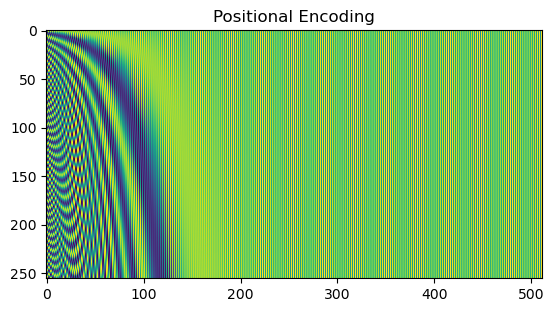

In [9]:
max_len = 256
d_model = 512

position_encoding_matrix = np.zeros((max_len, d_model))
position_ids = np.arange(max_len).reshape(max_len, 1)
dimension_ids = np.arange(d_model)

for p in position_ids:
    for i in dimension_ids:
        if i % 2 == 0:
            position_encoding_matrix[p, i] = np.sin(p / 10000**(2*i/d_model))
        else:
            position_encoding_matrix[p, i] = np.cos(p / 10000**(2*i/d_model))

plt.imshow(position_encoding_matrix)
plt.title('Positional Encoding')
plt.show()

#### VECTORIZED

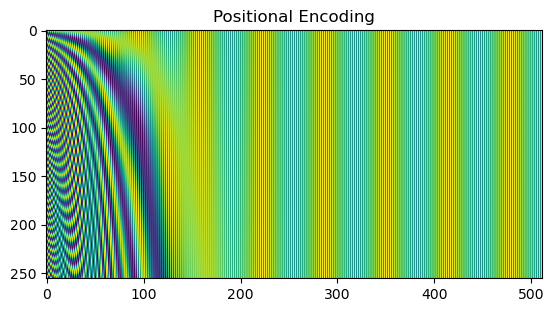

In [10]:
max_len = 256
d_model = 512

position_encoding_matrix = torch.zeros((max_len, d_model))
position_ids = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
dimension_ids = torch.arange(d_model, dtype=torch.float32)

position_encoding_matrix = torch.where(
    dimension_ids % 2 == 0,
    torch.sin(position_ids / 10000**(2*dimension_ids / d_model)), 
    torch.cos(position_ids / 10000**(2*dimension_ids / d_model)), 
)

import matplotlib.pyplot as plt
plt.imshow(position_encoding_matrix.numpy())
plt.title('Positional Encoding')
plt.show()

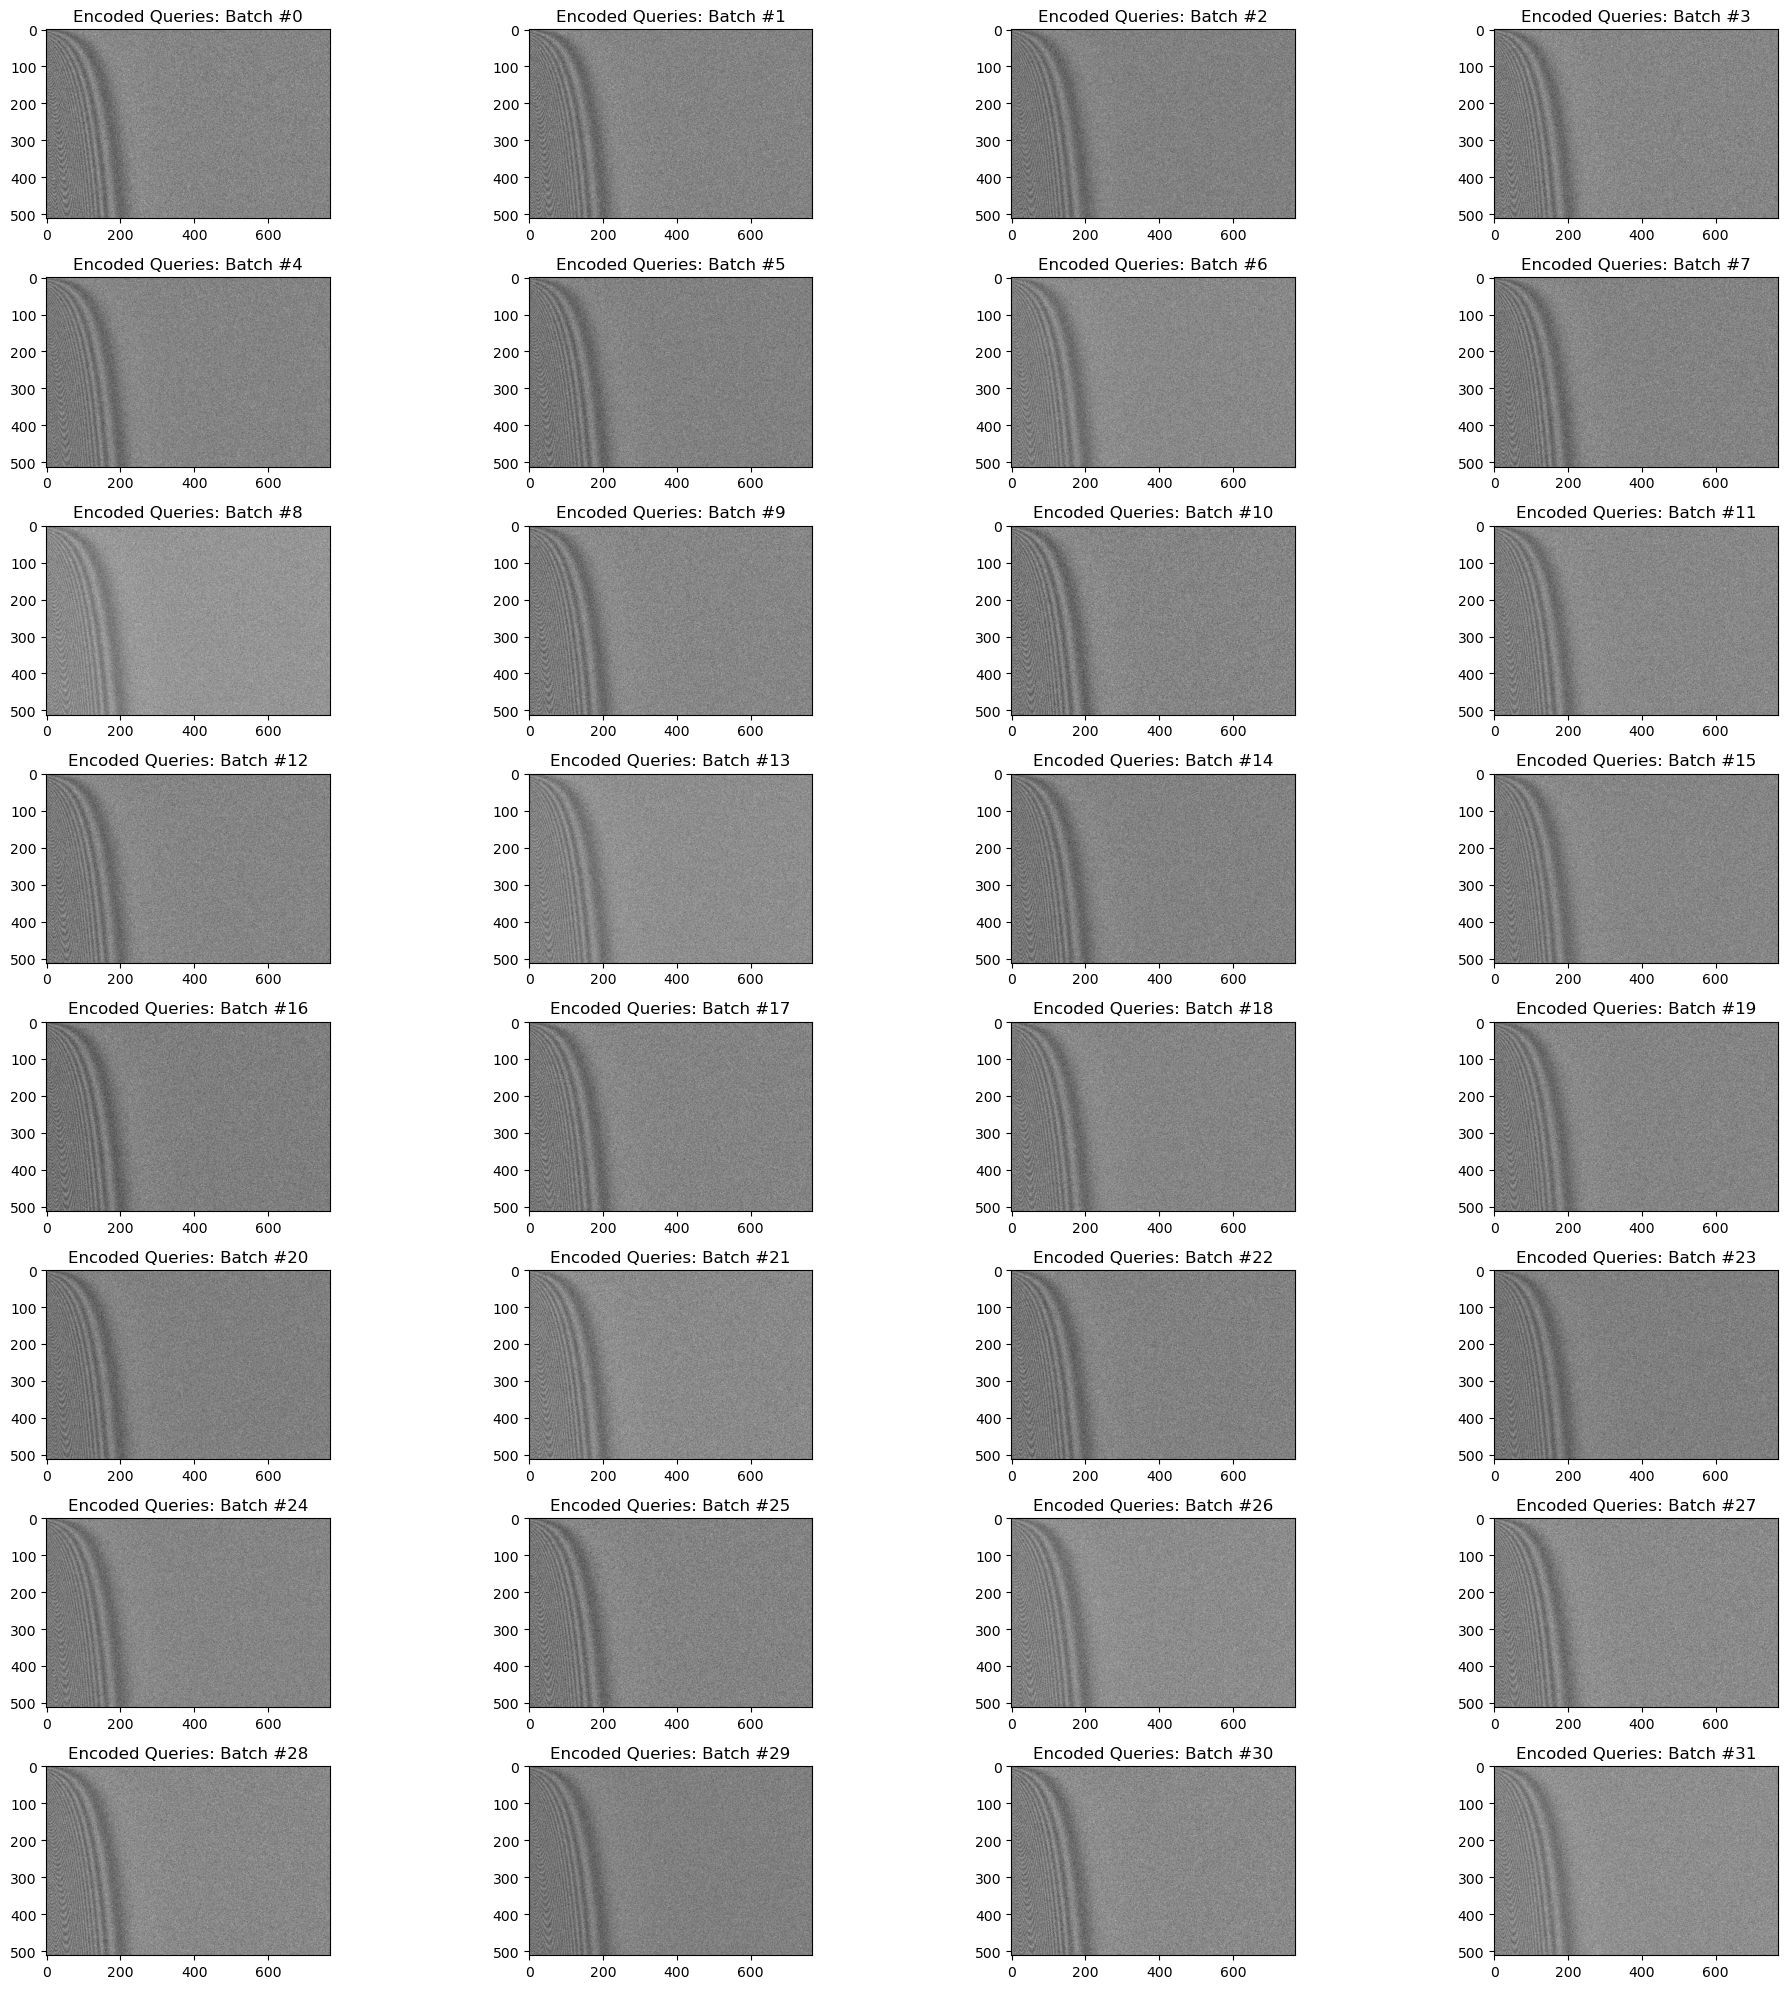

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 512, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.position_encoding_matrix = torch.zeros((max_len, d_model))
        position_ids = torch.arange(max_len).unsqueeze(1)
        dimension_ids = torch.arange(d_model)
        
        self.position_encoding_matrix = torch.where(
            dimension_ids % 2 == 0,
            torch.sin(position_ids / 10000**(2*dimension_ids / d_model)), 
            torch.cos(position_ids / 10000**(2*dimension_ids / d_model)), 
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print(self.position_encoding_matrix[:x.shape[0]].shape, x.shape)
        return x + self.position_encoding_matrix[:x.shape[1]] # Take sequence length

enc = PositionalEncoding(d_model=768)
new_queries = enc(queries)

fig, axs = plt.subplots(8, 4, figsize=(20, 20))
for batch, ax in enumerate(axs.flatten()):
    ax.imshow(new_queries.numpy()[batch], cmap='gray')
    ax.set_title(f'Encoded Queries: Batch #{batch}')

plt.tight_layout()
plt.show()